# Mutation correlations
In this notebook we will focus on each of the mutatons individually.

**NB**: These results are derived from the `2019-08-27_PLASMA_DEFAULT_Results_Groningen.xlsx` file containing mutation data of 122 patients. As far as I know, this file contains the mutations from the default filter only.

In [1]:
%matplotlib inline
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

from source import load_avenio_files
from transform import (
    clean_mutation_columns, 
    get_top_correlated, 
    patient_allele_frequencies,
)


RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [2]:
# Load data from spreadsheet and SPSS files.
mutation_data_frame, phenotypes = load_avenio_files()

In this document the mutation correlations will be calculated between $t_0$ and $t_1$. 
We consider the correlations for the following two quantities:
- allele frequencies $f_0$ and $f_1$ respectively,
- and the mutant concentration (molecules per ml) $c_0$ and $c_1$.

In [18]:
# Vocabulary is the entire dataset, not only training set. Otherwise we run into problems during inference.
gene_vocabulary = mutation_data_frame['Gene'].unique()

# Convert particular columns to numbers and drop rows with missing data.
mutation_data_frame = clean_mutation_columns(mutation_data_frame)

There are several ways to evaluate the development of mutation. One way is to calculate the relative difference
$$r(x) = \frac{\Delta x}{x_0} \equiv \frac{x_1 - x_0}{x_0} .$$
where $x$ is $f$ (allele frequency) or $c$ (mutant concentration). The advantage of $r(x)$ is that it is dimensionless [-], meaning that quantities such Avogadro's number $N_A$ drop out of the equation.

In [4]:
def r(t_0, t_1):
    return (t_1 - t_0) / t_0

Apart from the relative difference $r(x)$ there are also other ways to evaluate the growth, such as the ratio $x_1/x_0$ or the absolute difference $\Delta x$, but it turns out that these quantities lead to large variances amongst the patients, for a given mutation (results of which, are not shown here). I will therefore focus only on the relative difference $r(x)$.

Next, carry out the following steps:
1. For each patient: calculate $r(f)$/$r(c)$ for each gene mutation.
2. If there are multiple mutations in a single gene, sum the result $r(x) = \sum_i r(x_i)$.
3. Store result in a column corresponding to that mutation.

In [5]:
# Calculate allele frequencies r(f).
mutant_allele_frequencies = patient_allele_frequencies(
    mutation_data_frame, 
    gene_vocabulary, 
    # Calculate r(t_0, t_1).
    transformation=r,
    # Sum mutation values per gene in each patient.
    handle_duplicates="sum",
    allele_columns=["T0: Allele \nFraction", "T1: Allele Fraction"],
)

# Calculate mutant concentration r(c).
mutant_allele_concentration = patient_allele_frequencies(
    mutation_data_frame, 
    gene_vocabulary, 
    # Calculate r(t_0, t_1).
    transformation=r,
    # Sum mutation values per gene in each patient.
    handle_duplicates="sum",
    allele_columns=[
        "T0: No. Mutant \nMolecules per mL",
        "T1: No. Mutant \nMolecules per mL",
    ],
)

To give you an idea of the resulting table, let me give you the first few patient records for $r(f)$:

In [6]:
mutant_allele_frequencies.head()

,TP53,KRAS,FGFR1,PTEN,FBXW7,KDR,MTOR,EGFR,MET,CDKN2A,...,KIT,PTCH1,SMAD4,SMO,RNF43,FGFR2,JAK2,CCND1,GATA3,PDGFRA
951,-0.549501,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
952,0.593023,0.472863,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
957,0.605989,0.000000,0.166667,0.475,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
964,0.611307,0.086072,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
965,0.000000,0.000000,0.000000,0.000,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlations
Now that we have cleaned the data we can start calculating correlations for both $r(f)$ as well as $r(c)$. The goal: to see if either $r(f)$ or $r(c)$ lead to more pronounced correlations. 
We calculate the Pearson correlation value which is defined as:
$$C_{ij} = \sum_{m=1}^{N} \frac{(X_{mi} - \mu_i)(X_{mj} - \mu_j)}{\sigma_i \sigma_j} \, ,$$
with $\mu$ and $\sigma$ the mean and standard deviation, respectively.

In [7]:
# Extra function to calculate p-value for given Pearson correlation.
def pearson_pval(x, y):
    return pearsonr(x, y)[1]

## Allele frequency
Let us first focus on the relative difference in allele frequencies $r(f)$ and calculate the corresponding correlations:

In [8]:
corr = mutant_allele_frequencies.corr().fillna(0)
pval_corr = mutant_allele_frequencies.corr(method=pearson_pval).fillna(1)
corr.style.background_gradient(cmap='coolwarm', axis=None)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Negative correlation
Now, zoom in on the top anti-correlating genes. That is, a relative increase in allele frequency of gene $a$ is associated with a decrease in gene $b$, or vice versa.

In [9]:
gene_counts = mutation_data_frame['Gene'].value_counts()
get_top_correlated(
    corr, 
    pval_corr,
    gene_counts=gene_counts, 
    ascending=True, 
    top_count=4,
)

,gene 1,gene 2,correlation,p-value,# gene 1,# gene 2
0,NFE2L2,KDR,-0.583724,6.341728e-11,9.0,1.0
2,PTEN,CDKN2A,-0.333554,5.067958e-04,4.0,7.0
4,KRAS,SMO,-0.078985,4.231809e-01,37.0,1.0
6,TP53,PTEN,-0.050080,6.119164e-01,100.0,4.0


The last two columns indicate the number of mutations throughout the study. That is, there are 9 `NFE2L2` mutations in total, whilst there is only 1 `KDR` mutation in the entire study.

As a consequence, the p-values should not be taken to seriously. The fact that the p-values are extremely low is easy to understand:
- All columns are zero.
- Except the columns where the two unique mutations happen to coincide.
This immediately implies that the p-value should be near zero.

### Positive correlations
Likewise, calculate the top correlating genes. That is, both relative allele frequencies increase or decrease in concert.

In [10]:
pcorr_rf = get_top_correlated(corr, pval_corr, gene_counts=gene_counts, top_count=20, ascending=False)
pcorr_rf

,gene 1,gene 2,correlation,p-value,# gene 1,# gene 2
1762,MTOR,GATA3,1.000000,0.000000e+00,1.0,1.0
1726,CD274,MAP2K2,1.000000,0.000000e+00,1.0,1.0
1724,SMAD4,CTNNB1,0.999821,2.902454e-179,2.0,2.0
1722,STK11,GNAS,0.929957,1.470575e-46,4.0,1.0
1720,PTEN,FGFR1,0.660249,1.833417e-14,4.0,1.0
1718,JAK2,PIK3CA,0.534706,4.215318e-09,1.0,7.0
1716,FBXW7,PTEN,0.401111,2.230812e-05,4.0,4.0
1714,APC,KEAP1,0.396476,2.827031e-05,2.0,4.0
1712,SMO,STK11,0.375571,7.883190e-05,1.0,4.0
1710,TP53,KRAS,0.375138,8.046542e-05,100.0,37.0


Again, note the concordance of extremely rare mutations. As discussed above, these p values should be taken with a pinch of salt.

## Mutant concentration
Mutatis mutandis, we will now calculate the correlations for the relative difference in mutation concentration $r(c)$.

In [11]:
corr = mutant_allele_concentration.corr().fillna(0)
pval_corr = mutant_allele_concentration.corr(method=pearson_pval).fillna(1)
corr.style.background_gradient(cmap='coolwarm', axis=None)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Negative correlation

In [12]:
gene_counts = mutation_data_frame['Gene'].value_counts()
get_top_correlated(
    corr, 
    pval_corr,
    gene_counts=gene_counts, 
    ascending=True, 
    top_count=4,
)

,gene 1,gene 2,correlation,p-value,# gene 1,# gene 2
0,NFE2L2,KDR,-0.229295,0.018628,9.0,1.0
2,EGFR,TP53,-0.024328,0.805422,3.0,100.0
4,IDH1,TP53,-0.023403,0.812680,1.0,100.0
6,IDH1,KRAS,-0.022668,0.818462,1.0,37.0


Comparing these results with the negative correlations of $r(f)$ we find that negative correlations have decreased in absolute size. Importantly, the pair `NFE2L2` with `KDR` has remained the top anti-correlating mutation. But the remainder of the list has changed altogether.

### Positive correlation
Likewise, the list for top positive correlating mutations:

In [13]:
pcorr_rc = get_top_correlated(corr, pval_corr, gene_counts=gene_counts, top_count=20, ascending=False)
pcorr_rc

,gene 1,gene 2,correlation,p-value,# gene 1,# gene 2
1728,GATA3,MTOR,1.000000,0.000000e+00,1.0,1.0
1726,MAP2K2,CD274,1.000000,0.000000e+00,1.0,1.0
1724,FGFR1,PTEN,0.999488,8.337106e-156,1.0,4.0
1722,CTNNB1,SMAD4,0.999133,5.063927e-144,2.0,2.0
1720,GNAS,STK11,0.937039,7.274479e-49,1.0,4.0
1718,DDR2,KRAS,0.932631,2.121460e-47,1.0,37.0
1716,NFE2L2,GATA3,0.785798,3.187484e-23,9.0,1.0
1714,NFE2L2,MTOR,0.785798,3.187484e-23,9.0,1.0
1712,PIK3CA,MTOR,0.752624,2.102308e-20,7.0,1.0
1710,GATA3,PIK3CA,0.752624,2.102308e-20,1.0,7.0


Comparatively, the size of the top 20 correlating mutations have increased in size. 

## Do responders show an increase in mutational allel frequency?

Instead of looking at results per patient, consider now all the mutations and compare them according to the response. Again, we will group the results according to $r(f)$ and $r(c)$.

In [14]:
# Use the columns containing the allele frequencies.
mutation_data_frame["r(f)"] = r(
    mutation_data_frame["T0: Allele \nFraction"], mutation_data_frame["T1: Allele Fraction"]
)

# Use the columns containing the concentration.
mutation_data_frame["r(c)"] = r(
    mutation_data_frame["T0: No. Mutant \nMolecules per mL"], mutation_data_frame["T1: No. Mutant \nMolecules per mL"]
)

Combine records with patient response data.

In [15]:
mutation_data_frame['response'] = mutation_data_frame['Patient ID'].apply(lambda x: phenotypes.loc[x, 'response_grouped'])
mutation_data_frame['progression'] = mutation_data_frame['Patient ID'].apply(lambda x: phenotypes.loc[x, 'progressie'])

Since the occurences of most genes are extremely rare, only the top 4 most occuring gene mutations are shown:

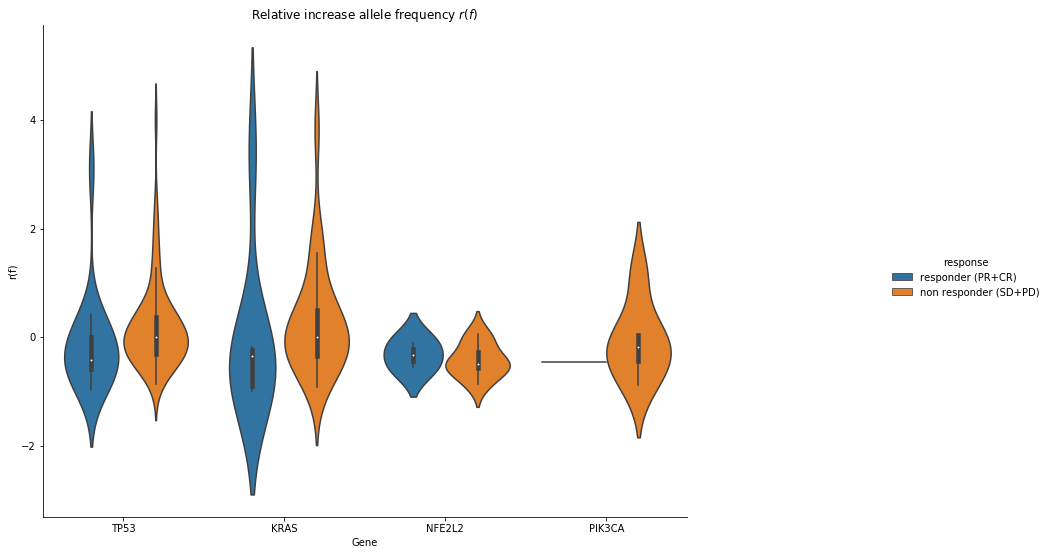

In [16]:
gene_subset = mutation_data_frame['Gene'].isin(['TP53', 'KRAS', 'PIK3CA', 'NFE2L2'])

g = sns.catplot(
    x='Gene', 
    y='r(f)', 
    hue='response',
    data=mutation_data_frame[gene_subset],
    kind='violin',
)
plt.title('Relative increase allele frequency $r(f)$')
g.fig.set_size_inches(16,8)

By looking carefully, it looks like responders have a slight decrease in $r(f)$ for `TP53` and `KRAS` compared to non-responders. For `NFE2l2` this looks like the other way around.

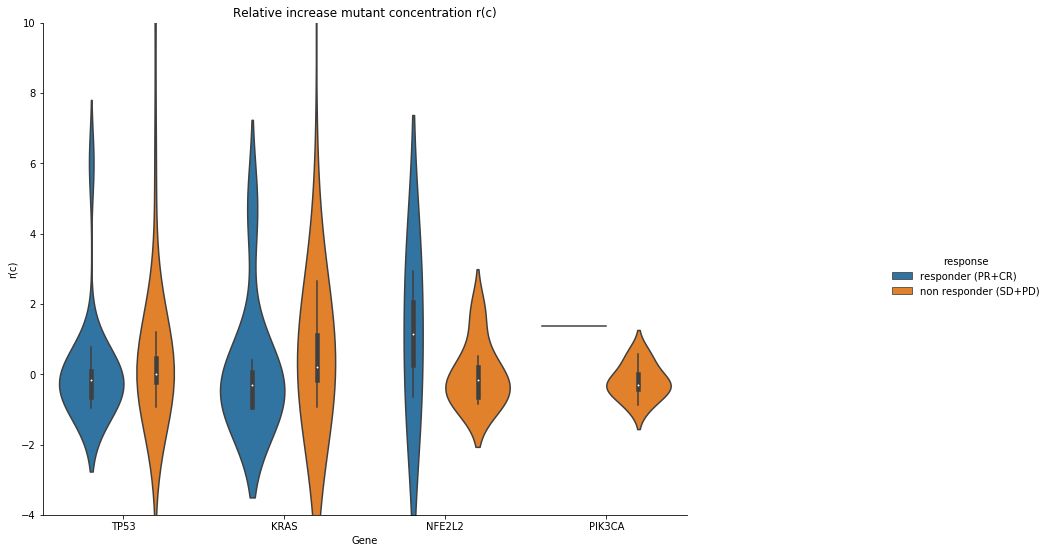

In [17]:
gene_subset = mutation_data_frame['Gene'].isin(['TP53', 'KRAS', 'PIK3CA', 'NFE2L2'])

g = sns.catplot(
    x='Gene', 
    y='r(c)', 
    hue='response',
    data=mutation_data_frame[gene_subset],
    kind='violin',
)
plt.title('Relative increase mutant concentration r(c)')
plt.ylim([-4, 10])
g.fig.set_size_inches(16,8)

Essentially the same conclusion cna be drawn based on the data from $r(c)$, but now with larger spread in the distributions.

# Conclusion

1. It looks like several gene mutations develop in concordance. But the correlations are seriously clouded by the accidental occurence of rare mutations (occuring only 1 or 2 times throughout the study).
2. Using the mutant concentration $r(c)$ (as opposed to the allele frequency $r(f)$) gives slightly elevated positive correlations.